In [34]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["image.cmap"] = 'magma'

from damo.config.base import parse_config
from tools.demo import Infer

In [157]:
import random
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import json

def create_collage(seed=42):

    def set_random_seed(seed):
        random.seed(seed)
        np.random.seed(seed)

    def load_coco_data(coco_ann_path, coco_img_dir):
        coco = COCO(coco_ann_path)
        img_ids = coco.getImgIds()
        return coco, img_ids, coco_img_dir

    def get_objects_from_different_classes(coco, img_ids, num_objects=50):
        selected_objects = []
        used_categories = set()

        random.shuffle(img_ids)
        for img_id in img_ids:
            img_info = coco.loadImgs(img_id)[0]
            img_area = img_info['width'] * img_info['height']
            ann_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(ann_ids)

            for ann in anns:
                cat_id = ann['category_id']
                bbox = ann['bbox']
                bbox_area = bbox[2] * bbox[3]
                area_ratio = bbox_area / img_area

                if cat_id not in used_categories and 0.1 <= area_ratio <= 0.2:
                    selected_objects.append((img_id, ann))
                    used_categories.add(cat_id)
                    if len(selected_objects) == num_objects:
                        return selected_objects
        return selected_objects

    def extract_bbox_objects(coco, img_dir, objects):
        extracted_objects = []
        for img_id, ann in objects:
            img_info = coco.loadImgs(img_id)[0]
            img_path = f"{img_dir}/{img_info['file_name']}"
            img = cv2.imread(img_path)
            x, y, w, h = map(int, ann['bbox'])
            cropped_obj = img[y:y+h, x:x+w]
            extracted_objects.append((cropped_obj, ann['category_id'], ann['bbox']))
        return extracted_objects

    def get_background_patch(img, occupied_regions):
        h, w, _ = img.shape
        mask = np.zeros((h, w), dtype=np.uint8)
        for x, y, x2, y2 in occupied_regions:
            mask[y:y2, x:x2] = 1

        patch_size = min(h, w) // 5
        corners = [(0, 0), (0, w - patch_size), (h - patch_size, 0), (h - patch_size, w - patch_size)]
        random.shuffle(corners)

        for y, x in corners:
            if np.all(mask[y:y+patch_size, x:x+patch_size] == 0):
                return img[y:y+patch_size, x:x+patch_size], [x, y, patch_size, patch_size]
        return None, None

    def create_collage(bg_img, objects, occupied_regions):
        h, w, _ = bg_img.shape
        collage = bg_img.copy()
        positions = []
        placed_regions = occupied_regions.copy()
        bg_mask = np.zeros((h, w), dtype=np.uint8)

        added_objects = 0
        max_attempts_per_object = 50
        random.shuffle(objects)

        while added_objects < 3 and objects:
            obj, class_id, bbox = objects.pop(0)
            oh, ow, _ = obj.shape
            if oh > h or ow > w:
                continue  # Пропускаем слишком большие объекты

            for _ in range(max_attempts_per_object):
                x, y = random.randint(0, w-ow), random.randint(0, h-oh)
                region = (x, y, x+ow, y+oh)

                if not any(overlaps(region, placed) for placed in placed_regions) and np.all(bg_mask[y:y+oh, x:x+ow] == 0):
                    placed_regions.append(region)
                    bg_mask[y:y+oh, x:x+ow] = 1
                    collage[y:y+oh, x:x+ow] = obj
                    positions.append({'bbox': [x, y, ow, oh], 'category_id': class_id})
                    added_objects += 1
                    break

        return collage, positions, placed_regions

    def overlaps(region1, region2):
        x1_min, y1_min, x1_max, y1_max = region1
        x2_min, y2_min, x2_max, y2_max = region2
        return not (x1_max <= x2_min or x1_min >= x2_max or y1_max <= y2_min or y1_min >= y2_max)

    set_random_seed(seed)

    # Загрузка COCO
    coco_ann_path = './datasets/coco/' + 'annotations/instances_val2017.json'
    coco_img_dir = './datasets/coco/val2017'
    coco, img_ids, img_dir = load_coco_data(coco_ann_path, coco_img_dir)

    # Фон
    bg_img_info = coco.loadImgs(785)[0]
    bg_img_path = f"{img_dir}/{bg_img_info['file_name']}"
    bg_img = cv2.imread(bg_img_path)

    # Получение объектов
    objects = get_objects_from_different_classes(coco, img_ids)
    extracted_objects = extract_bbox_objects(coco, img_dir, objects)

    # Определение уже занятых областей на фоновой картинке
    occupied_regions = [
        (int(ann['bbox'][0]), int(ann['bbox'][1]), int(ann['bbox'][0] + ann['bbox'][2]), int(ann['bbox'][1] + ann['bbox'][3]))
        for ann in coco.loadAnns(coco.getAnnIds(imgIds=785))
    ]

    # Создание коллажа
    collage, new_annotations, final_occupied_regions = create_collage(bg_img, extracted_objects, occupied_regions)

    # Добавление объектов из фонового изображения в аннотации
    new_annotations.extend([{'bbox': ann['bbox'], 'category_id': ann['category_id']} for ann in coco.loadAnns(coco.getAnnIds(imgIds=785))])

    # Получение фонового патча
    bg_patch, bg_patch_bbox = get_background_patch(collage, final_occupied_regions)
    if bg_patch is not None:
        background_annotation = {'bbox': bg_patch_bbox, 'category_id': 'background'}
        new_annotations.append(background_annotation)

    # Вывод названий классов
    class_names = [coco.loadCats(ann['category_id'])[0]['name'] if ann['category_id'] != 'background' else 'background' for ann in new_annotations]
    print("Классы в new_annotations:", class_names)

    # Сохранение результата
    cv2.imwrite(f"collage_{seed}.jpg", collage)
    with open(f"annotations_{seed}.json", "w") as f:
        json.dump(new_annotations, f, indent=4)

    # Отображение результата
    plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Классы в new_annotations: ['airplane', 'horse', 'tennis racket', 'person', 'skis', 'background']


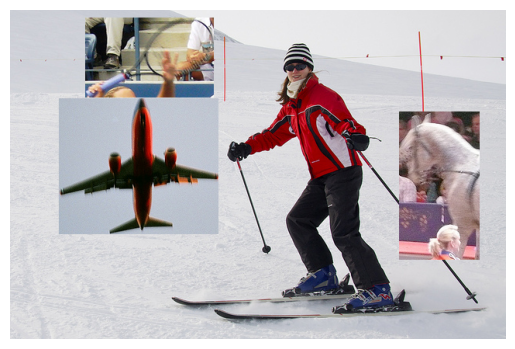

In [169]:
create_collage(19)

Inference with torch engine!


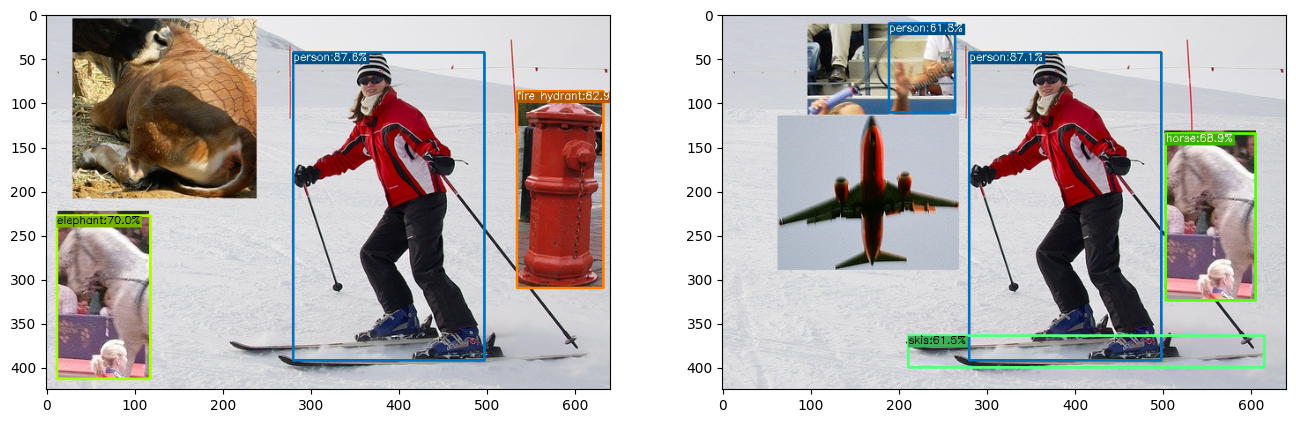

In [172]:
config = parse_config('./configs/damoyolo_tinynasL20_T.py')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

infer_engine = Infer(config, device='cuda',
    ckpt='./weights/damoyolo_tiny.pth')

conf = 0.6
save_result = False

path = './collage_2.jpg'
origin_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
bboxes, scores, cls_inds = infer_engine.forward(origin_img)
vis_res = infer_engine.visualize(origin_img, bboxes, scores, cls_inds, conf=conf, save_name=os.path.basename(path), save_result=save_result)
axes[0].imshow(vis_res)
path = './collage_19.jpg'
origin_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
bboxes, scores, cls_inds = infer_engine.forward(origin_img)
vis_res = infer_engine.visualize(origin_img, bboxes, scores, cls_inds, conf=conf, save_name=os.path.basename(path), save_result=save_result)
axes[1].imshow(vis_res)

plt.show();

In [12]:
coco_ann_path = './datasets/coco/' + 'annotations/instances_val2017.json'
coco_img_dir = './datasets/coco/val2017'

[{'bbox': [0, 0, 640, 480], 'category_id': 44}]

In [156]:
new_annotations

[{'bbox': [106, 31, 166, 241], 'category_id': 47},
 {'bbox': [511, 33, 113, 270], 'category_id': 19},
 {'bbox': [280.79, 44.73, 218.7, 346.68], 'category_id': 1},
 {'bbox': [205.34, 362.21, 409.72, 38.2], 'category_id': 35},
 {'bbox': [0, 340, 85, 85], 'category_id': 'background'}]

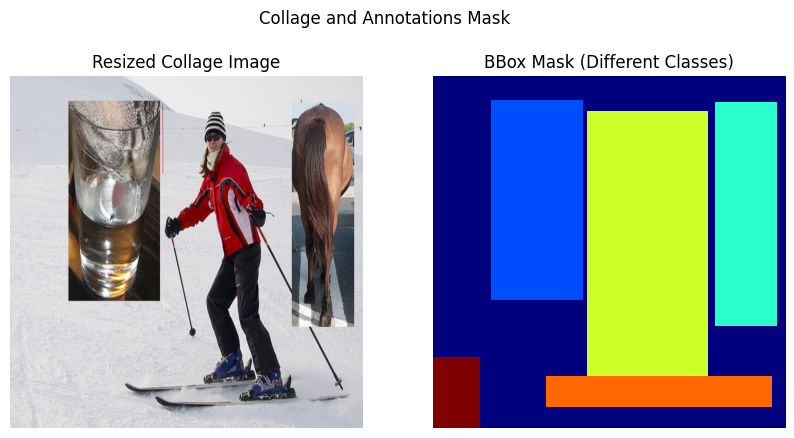

In [173]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# Пути к файлам
collage_path = "collage_1.jpg"  # Изображение коллажа
annotations_path = "annotations_1.json"  # Аннотации

# Загружаем аннотации
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Загружаем изображение
image = cv2.imread(collage_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация BGR -> RGB
h, w, _ = image.shape

# Изменяем размер до 640x640
image_resized = cv2.resize(image, (640, 640))

# Создаём пустую маску (0 - фон)
mask = np.zeros((640, 640), dtype=np.uint8)

# Наносим bbox на маску, каждому классу даём уникальный индекс
class_to_id = {}  # Словарь: category_id -> уникальный индекс
next_class_id = 1  # Начинаем индексацию классов с 1

for ann in annotations:
    category_id = ann["category_id"]
    if category_id not in class_to_id:
        class_to_id[category_id] = next_class_id
        next_class_id += 1
    
    mask_value = class_to_id[category_id]  # Уникальный ID класса на маске
    x, y, w_bbox, h_bbox = map(int, ann["bbox"])
    
    # Масштабируем bbox под 640x640
    x = int(x * 640 / w)
    y = int(y * 640 / h)
    w_bbox = int(w_bbox * 640 / w)
    h_bbox = int(h_bbox * 640 / h)
    
    # Заполняем область bbox значением класса
    mask[y:y+h_bbox, x:x+w_bbox] = mask_value

# Визуализируем изображение и маску
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image_resized)
ax[0].set_title("Resized Collage Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="jet", interpolation="nearest")
ax[1].set_title("BBox Mask (Different Classes)")
ax[1].axis("off")

plt.suptitle("Collage and Annotations Mask")
plt.show()


In [174]:
from my_help_functions.cosine_matrix import get_positions_of_classes_on_flattened_image, get_positions_of_classes_on_flattened_image_for_collage

In [176]:
positions = get_positions_of_classes_on_flattened_image_for_collage(1, 80)
positions

{1: array([ 413,  414,  415,  416,  417,  418,  419,  420,  421,  422,  423,
         424,  425,  426,  427,  428,  429,  430,  431,  432,  493,  494,
         495,  496,  497,  498,  499,  500,  501,  502,  503,  504,  505,
         506,  507,  508,  509,  510,  511,  512,  573,  574,  575,  576,
         577,  578,  579,  580,  581,  582,  583,  584,  585,  586,  587,
         588,  589,  590,  591,  592,  653,  654,  655,  656,  657,  658,
         659,  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,
         670,  671,  672,  733,  734,  735,  736,  737,  738,  739,  740,
         741,  742,  743,  744,  745,  746,  747,  748,  749,  750,  751,
         752,  813,  814,  815,  816,  817,  818,  819,  820,  821,  822,
         823,  824,  825,  826,  827,  828,  829,  830,  831,  832,  893,
         894,  895,  896,  897,  898,  899,  900,  901,  902,  903,  904,
         905,  906,  907,  908,  909,  910,  911,  912,  973,  974,  975,
         976,  977,  978,  979,  98